In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import os

In [3]:
#print the list of paths of files in the training set
set_path = 'train'
paths = sorted(glob.glob(f'data/{set_path}/*.hdf5'))
print(paths)

['data/train/helmholtz_staircase_omega_006.hdf5', 'data/train/helmholtz_staircase_omega_02.hdf5', 'data/train/helmholtz_staircase_omega_04.hdf5', 'data/train/helmholtz_staircase_omega_06.hdf5', 'data/train/helmholtz_staircase_omega_08.hdf5', 'data/train/helmholtz_staircase_omega_09.hdf5', 'data/train/helmholtz_staircase_omega_11.hdf5', 'data/train/helmholtz_staircase_omega_13.hdf5', 'data/train/helmholtz_staircase_omega_15.hdf5', 'data/train/helmholtz_staircase_omega_17.hdf5', 'data/train/helmholtz_staircase_omega_18.hdf5', 'data/train/helmholtz_staircase_omega_20.hdf5', 'data/train/helmholtz_staircase_omega_21.hdf5', 'data/train/helmholtz_staircase_omega_23.hdf5', 'data/train/helmholtz_staircase_omega_24.hdf5', 'data/train/helmholtz_staircase_omega_25.hdf5']


In [4]:
#select the first path (arbitrary choice)
p = paths[10]

#print the first layer of keys
with h5py.File(p,'r') as f:
    print(f.keys())

<KeysViewHDF5 ['boundary_conditions', 'dimensions', 'scalars', 't0_fields', 't1_fields', 't2_fields']>


In [5]:
# In 'boundary_conditions' is stored the information about the boundary conditions:
#/!\ : This dataset has a special boundary condition: a staircase:
with h5py.File(p,'r') as f:
    print('print bc available:', f['boundary_conditions'].keys())
    print('print attributes of the bc:', f['boundary_conditions']['xy_wall'].attrs.keys()) 
    print('get the bc type:', f['boundary_conditions']['xy_wall'].attrs['bc_type'])

print bc available: <KeysViewHDF5 ['x_open_neumann', 'xy_wall', 'y_open_neumann']>
print attributes of the bc: <KeysViewHDF5 ['associated_dims', 'associated_fields', 'bc_type', 'sample_varying', 'time_varying']>
get the bc type: wall


In [6]:
#Reminder: 't0_fields', 't1_fields', 't2_fields' are respectively scalar fields, vector fields and tensor fields
#print the different fields available in the dataset
with h5py.File(p,'r') as f:
    print('t0_fields:', f['t0_fields'].keys())
    print('t1_fields:', f['t1_fields'].keys())
    print('t2_fields:', f['t2_fields'].keys())

t0_fields: <KeysViewHDF5 ['pressure_im', 'pressure_re']>
t1_fields: <KeysViewHDF5 []>
t2_fields: <KeysViewHDF5 []>


In [7]:
#The data is of shape (n_trajectories, n_timesteps, x, y)
#Get the first t0_field and save it as a numpy array
with h5py.File(p,'r') as f:
    pressure_re = f['t0_fields']['pressure_re'][:] #HDF5 datasets can be sliced like a numpy array
    print(f'shape of the selected t0_field: ', pressure_re.shape)   
    #you can directly slice the selected field without reading the whole dataset by doing:
    #traj = 0 #select the trajectory
    # field = f['t0_fields']['concentration'][traj, :] 

shape of the selected t0_field:  (26, 50, 1024, 256)


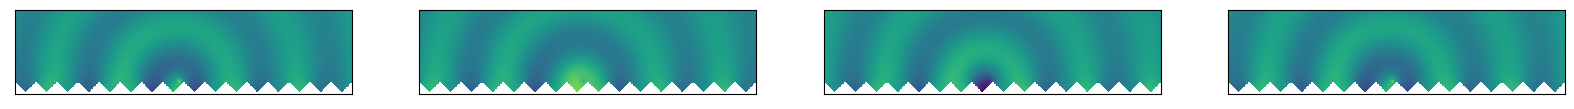

In [11]:
import matplotlib.patches as patches
traj = 1 #select the trajectory
traj_toplot = pressure_re[traj]
#field is now of shape (n_timesteps, x, y). Let's do a subplot to plot it at t= 0, t= T/3, t= 2T/3 and t= T:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
T = traj_toplot.shape[0]
#fix colorbar for all subplots:
vmin = np.nanmin(traj_toplot) #The nans are the staircase boundary conditions
vmax = np.nanmax(traj_toplot)
norm = plt.Normalize(vmin=vmin, vmax=vmax)

for i, t in enumerate([0, T//3, (2*T)//3, T-1]):
    axs[i].imshow(traj_toplot[t].T, cmap='viridis', norm=norm,)
    #no ticks:
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=axs[i])
    #axs[i].set_title(f't={t}')



In [43]:
#save figure without axes and titles:

image_name = 'helmholtz_staircase_normalized'
path_to_save = '/mnt/home/polymathic/ceph/the_well/viz/'
fig.savefig(f'{path_to_save}{image_name}.png', bbox_inches='tight', pad_inches=0.05)

In [48]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
def create_gif(time_series, saving_directory, name_file = 'concentration', delete_imgs=False):
    time_series_min = np.nanmin(time_series)
    time_series_max = np.nanmax(time_series)
    if time_series.ndim > 3:
        #error:
        print('Error: The time series should be (time, height, width)')
        return
    if not os.path.exists(saving_directory + '/img_for_gif'):
        os.makedirs(saving_directory + '/img_for_gif')
    images = []
    for i in range(time_series.shape[0]):
        plt.imshow(time_series[i], origin='lower')#, vmin=time_series_min, vmax=time_series_max);
        #plt.show()
        plt.axis('off')
        plt.savefig(saving_directory + f'/img_for_gif/time_series_{i}.png', bbox_inches='tight', pad_inches=0)
        plt.close()
        images.append(imageio.imread(saving_directory + f'/img_for_gif/time_series_{i}.png'))

    imageio.mimsave(saving_directory + '/' + name_file + '.gif', images, duration=0.1)
    if delete_imgs:
        shutil.rmtree(saving_directory + '/img_for_gif')

In [49]:
create_gif(pressure_re[0], 'gif', name_file='pressure_re_unnormalized', delete_imgs=True)

/tmp/ipykernel_3146684/4099231188.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(saving_directory + f'/img_for_gif/time_series_{i}.png'))
